In [ ]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
df=pd.read_csv('/content/drive/MyDrive/anime/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [ ]:
# Checking if there are any duplicate rows
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


# **Data Pre-Processing**

In [ ]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [ ]:
df["user_id"].nunique()

270033

In [ ]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 270033, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


# **Model training (collaborative filtering)**

In [ ]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [ ]:
test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 24315191
Number of samples in the test set: 10000


In [ ]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
# Setting TPU_INIT flag
USE_TPU = True

# Checking if TPU is initialized
if USE_TPU:
    # If tpu is connected then start creating TPUStrategy
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
else:
    !nvidia-smi

# Print the TensorFlow version
tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")

TensorFlow version: 2.12.0


In [ ]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)

    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)

    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)

    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)

    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])

    return model
# Checking if TPU is initialized and create the model accordingly
if USE_TPU:
    with tpu_strategy.scope():
        model = RecommenderNet(num_users, num_animes)
else:
    model = RecommenderNet(num_users, num_animes)

# Printing my model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_encoded (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 anime_encoded (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       34564224    ['user_encoded[0][0]']           
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2112000     ['anime_encoded[0][0]']          
                                                                                              

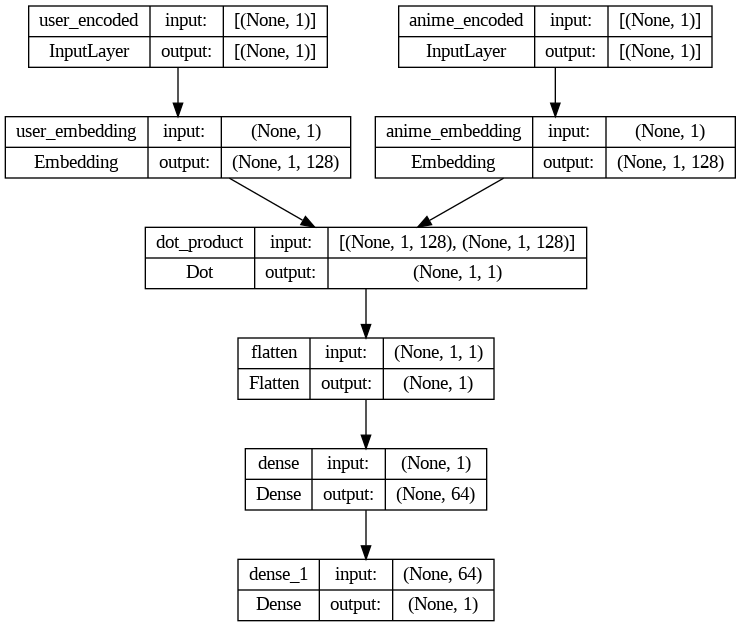

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the maximum learning rate and batch size if using TPU
if USE_TPU:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/content/myanimeweights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [ ]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/10
304/304 [==============================] - 33s 65ms/step - loss: 0.6903 - mae: 0.2611 - mse: 0.0883 - val_loss: 0.6882 - val_mae: 0.2587 - val_mse: 0.0868 - lr: 1.0000e-05
Epoch 2/10
304/304 [==============================] - 13s 42ms/step - loss: 0.6673 - mae: 0.2397 - mse: 0.0768 - val_loss: 0.6439 - val_mae: 0.2163 - val_mse: 0.0648 - lr: 8.8000e-05
Epoch 3/10
304/304 [==============================] - 13s 42ms/step - loss: 0.6074 - mae: 0.1799 - mse: 0.0477 - val_loss: 0.5804 - val_mae: 0.1494 - val_mse: 0.0350 - lr: 1.6600e-04
Epoch 4/10
304/304 [==============================] - 12s 41ms/step - loss: 0.5604 - mae: 0.1285 - mse: 0.0276 - val_loss: 0.5479 - val_mae: 0.1148 - val_mse: 0.0224 - lr: 2.4400e-04
Epoch 5/10
304/304 [==============================] - 13s 42ms/step - loss: 0.5396 - mae: 0.1065 - mse: 0.0196 - val_loss: 0.5402 - val_mae: 0.1068 - val_mse: 0.0196 - lr: 3.2200e-04
Epoch 6/10
304/304 [==============================] - 12s 41ms/step - loss: 0.5308 - 

In [ ]:
model.load_weights(checkpoint_filepath)

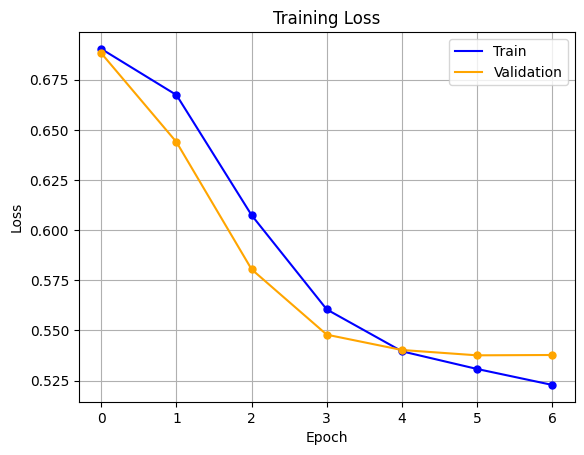

In [ ]:
import matplotlib.pyplot as plt

# Plotting training loss and validation loss
plt.plot(history.history["loss"][0:-2], color='blue', linestyle='-')
plt.plot(history.history["val_loss"][0:-2], color='orange', linestyle='-')

# Adding smoothness with marker
plt.plot(history.history["loss"][0:-2], marker='o', markersize=5, color='blue', linewidth=0)
plt.plot(history.history["val_loss"][0:-2], marker='o', markersize=5, color='orange', linewidth=0)

# Adding grid lines
plt.grid(True)

# Adding title and labels
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Adding legend
plt.legend(["Train", "Validation"], loc="upper right")

# Show plot
plt.show()


In [ ]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)

    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]

    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))

    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

In [ ]:
df_anime=pd.read_csv('/content/drive/MyDrive/anime/anime-dataset-2023.csv')

In [ ]:
popularity_threshold = 50
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(3)      # only give rating of those movies for which atleast 200 user have rated

(22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity has expanded across the galaxy, filling the surface of other planets with settlements like those on Earth. These new societies are plagued by murder, drug use, and theft, and intergalactic outlaws are hunted by a growing number of tough bounty hunters.\n\nSpike Spiegel and Jet Black pursue criminals throughout space to make a humble living. Beneath his goofy and aloof demeanor, Spike is haunted by the weight of his violent past. Meanwhile, Jet manages his own troubled memories while taking care of Spike and the Bebop, their ship. The duo is joined by the beautiful con artist Faye Valentine, odd child Edward Wong Hau Pepelu Tivrusky IV, and Ein, a bioengineered Welsh Corgi.\n\nWhile developing bonds and working to catch a colorful cast of criminals, the Bebop crew's lives are disrupted by a menace from Spike's past. As a rival's maniacal plot continues to unravel, Spike must choose between life with his newfound family or revenge for his old wounds.",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/19644.jpg
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator.\n\nWith lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized.",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/93480.jpg
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs.\n\nWith his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point.",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/20310.jpg


# **Collaborative Filtering**: Item Based Recommendation

In [ ]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        anime_row = df_anime[df_anime['Name'] == name].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('Animes closest to {}'.format(name))
        if return_dist:
            return dists, closest

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]

            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            Synopsis = anime_frame['Synopsis'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis":Synopsis})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]
    except:
        print('{} not found in Anime list'.format(name))

pd.set_option('display.max_colwidth', None)

In [ ]:
find_similar_animes('Shingeki no Kyojin', n=5, neg=False)  # That Time I Got Reincarnated as a Slime

Animes closest to Shingeki no Kyojin


,Name,Similarity,Genres,Synopsis
4,Death Note,84.29%,"Supernatural, Suspense","Brutal murders, petty thefts, and senseless violence pollute the human world. In contrast, the realm of death gods is a humdrum, unchanging gambling den. The ingenious 17-year-old Japanese student Light Yagami and sadistic god of death Ryuk share one belief: their worlds are rotten.\n\nFor his own amusement, Ryuk drops his Death Note into the human world. Light stumbles upon it, deeming the first of its rules ridiculous: the human whose name is written in this note shall die. However, the temptation is too great, and Light experiments by writing a felon's name, which disturbingly enacts his first murder.\n\nAware of the terrifying godlike power that has fallen into his hands, Light—under the alias Kira—follows his wicked sense of justice with the ultimate goal of cleansing the world of all evil-doers. The meticulous mastermind detective L is already on his trail, but as Light's brilliance rivals L's, the grand chase for Kira turns into an intense battle of wits that can only end when one of them is dead."
3,Attack on Titan Season 2,83.19%,"Action, Drama, Suspense","For centuries, humanity has been hunted by giant, mysterious predators known as the Titans. Three mighty walls—Wall Maria, Rose, and Sheena—provided peace and protection for humanity for over a hundred years. That peace, however, was shattered when the Colossal Titan and Armored Titan appeared and destroyed the outermost wall, Wall Maria. Forced to retreat behind Wall Rose, humanity waited with bated breath for the Titans to reappear and destroy their safe haven once more.\n\nIn Shingeki no Kyojin Season 2, Eren Yeager and others of the 104th Training Corps have just begun to become full members of the Survey Corps. As they ready themselves to face the Titans once again, their preparations are interrupted by the invasion of Wall Rose—but all is not as it seems as more mysteries are unraveled. As the Survey Corps races to save the wall, they uncover more about the invading Titans and the dark secrets of their own members."
2,Code Geass: Lelouch of the Rebellion R2,81.95%,"Action, Award Winning, Drama, Sci-Fi","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. \n\nLelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
1,Attack on Titan Season 3 Part 2,81.85%,"Action, Drama","Seeking to restore humanity's diminishing hope, the Survey Corps embark on a mission to retake Wall Maria, where the battle against the merciless ""Titans"" takes the stage once again.\n\nReturning to the tattered Shiganshina District that was once his home, Eren Yeager and the Corps find the town oddly unoccupied by Titans. Even after the outer gate is plugged, they strangely encounter no opposition. The mission progresses smoothly until Armin Arlert, highly suspicious of the enemy's absence, discovers distressing signs of a potential scheme against them. \n\nShingeki no Kyojin Season 3 Part 2 follows Eren as he vows to take back everything that was once his. Alongside him, the Survey Corps strive—through countless sacrifices—to carve a path towards victory and uncover the secrets locked away in the Yeager family's basement."
0,ERASED,80.92%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujin

In [ ]:
find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False)

Animes closest to Shigatsu wa Kimi no Uso


,Name,Similarity,Genres,Synopsis
4,Your Name.,87.98%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,A Silent Voice,86.79%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends.\n\nKoe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
2,Steins;Gate: The Movie - Load Region of Déjà Vu,85.79%,"Drama, Sci-Fi","After a year in America, Kurisu Makise returns to Akihabara and reunites with Rintarou Okabe. However, their reunion is cut short when Okabe begins to experience recurring flashes of other timelines as the consequences of his time traveling start to manifest. These side effects eventually culminate in Okabe suddenly vanishing from the world, and only the startled Kurisu has any memory of his existence.\n\nIn the midst of despair, Kurisu is faced with a truly arduous choice that will test both her duty as a scientist and her loyalty as a friend: follow Okabe's advice and stay away from traveling through time to avoid the potential consequences it may have on the world lines, or ignore it to rescue the person that she cherishes most. Regardless of her decision, the path she chooses is one that will affect the past, the present, and the future."
1,Anohana: The Flower We Saw That Day,84.77%,"Drama, Supernatural","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago.\n\nAt first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
0,ERASED,84.22%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save man

# **Collaborative Filtering**: User Based Recommendation

In [ ]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        SimilarityArr = []

        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [ ]:
# Select a random user
ratings_per_user = df.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

# Find similar users to the random user
similar_users = find_similar_users(random_user, n=10, neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

,similar_users,similarity
9,1225891,0.418347
8,6658,0.418054
7,646647,0.412816


In [ ]:
# Function to display a word cloud of preferred genres
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = df[df['user_id'] == user_id]

    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )

    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]

    if verbose != 0:
        print("User \033[1m{}\033[0m has watched {} anime(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(animes_watched_by_user), animes_watched_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred genres----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))

    return anime_df_rows

User 318120 has watched 72 anime(s) with an average rating of 8.6/10

----- Preferred genres----- 



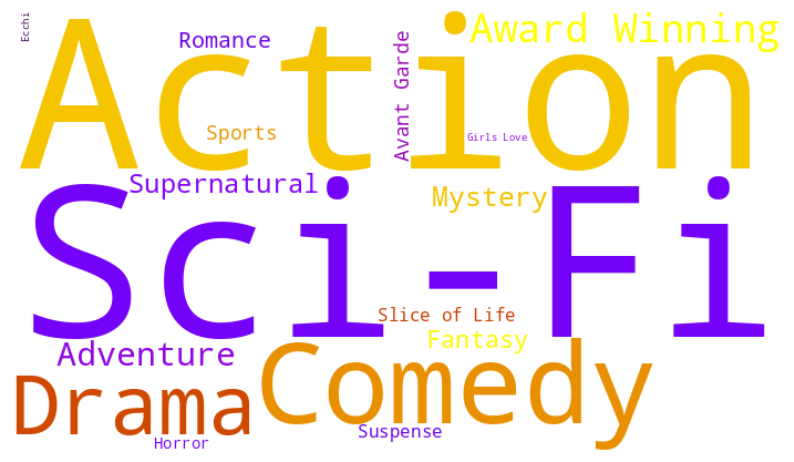

,Name,Genres
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi"
1,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi"
24,Koukaku Kidoutai,"Action, Award Winning, Mystery, Sci-Fi, Suspense"
28,Akira,"Action, Adventure, Horror, Sci-Fi, Supernatural"
47,Azumanga Daiou The Animation,"Comedy, Slice of Life"


In [ ]:
# Get user preferences for the random user
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

In [ ]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)

    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()

    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()

    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)  # Get the total count of users who have watched this anime
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)

In [ ]:
# Get recommended animes for the random user
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 1213175


,n,anime_name,Genres,Synopsis
0,22486,Ookami to Koushinryou II,"Adventure, Fantasy, Romance","Traveling merchant Kraft Lawrence continues his northward journey with wolf goddess Holo, in search of her lost home of Yoitsu. Lawrence and his sharp-witted partner continue to make some small profits along the way, while slowly uncovering more information about Holo's hometown. However, the road to Yoitsu is a bumpy one filled with many troubles—Lawrence runs into a charming young fellow merchant who has his eyes set on the female wolf companion, and he begins to doubt if Holo will remain by his side; he and the goddess will also have to consider precarious and risky business deals as Lawrence strives to achieve his dream of becoming a shopowner. All the while, with his determination tested at every turn during his journey, Lawrence must question his relationship with Holo, take on business ventures, and ask himself whether it is time for him and Holo to go their separate ways."
1,20864,Ga-Rei: Zero,"Action, Supernatural, Suspense","In Japan, there exists a government agency known as the Supernatural Disaster Countermeasures Division (SDCD), whose duty is to protect the citizens from creatures unseen. They are able to dispatch these monsters swiftly and without alerting the general public. But currently, they face a different challenge: the betrayal of one of their own.\n\nAfter the death of her mother several years ago, Kagura Tsuchimiya has been fostered by the Isayama family and forms a close sister-like bond with their daughter Yomi. The two become inseparable, and together they work for the SDCD as highly skilled exorcists. However, as the stress and consequences of their sacred duty weigh on them both, and family politics come into play, Kagura and Yomi begin to slowly drift apart. One of them grows earnestly into her role as an exorcist, and the other heads down a dark path from which there may be no redemption."
2,36094,Mirai Nikki (TV),"Action, Supernatural, Suspense","Yukiteru Amano is a shy middle schooler who regularly keeps track of what he does in his daily life by writing down all of his activities on his phone—a digital diary. Despite having no friends at school, Yukiteru is frequently seen talking to his supposedly imaginary friends Deus Ex Machina, the god of time and space; and Deus' servant, Mur Mur.\n\nOne day, Yukiteru wakes up and discovers that certain events of his day are preemptively displayed on his cellphone. While initially dismissing it as a coincidence, he slowly realizes that the incidents written in his phone actually take place in the near future. After spending the day benefiting from this new asset, Yukiteru learns that his classmate Yuno Gasai possesses a similar diary.\n\nAs the two team up to defeat an odd pursuer and head back to their respective homes, Deus Ex Machina explains that they—alongside 10 other contestants—have been drawn into a survival game whose victor will become the deity's successor. With no other options, Yukiteru and Yuno must use their cellphones—now called ""Future Diaries""—to survive this unforgiving battle royale."
3,23222,Danshi Koukousei no Nichijou,Comedy,"Roaming the halls of the all-boys Sanada North High School are three close comrades: the eccentric ringleader with a hyperactive imagination Hidenori, the passionate Yoshitake, and the rational and prudent Tadakuni. Their lives are filled with giant robots, true love, and intense drama... in their colorful imaginations, at least. In reality, they are just an everyday trio of ordinary guys trying to pass the time, but who said everyday life couldn't be interesting? Whether it's an intricate RPG reenactment or an unexpected romantic encounter on the riverbank at sunset, Danshi Koukousei no Nichijou is rife with bizarre yet hilariously relatable situations that are anything but mundane."
4,10129,Berserk: Ougon Jidai-hen I - Haou no Tamago,"Action, Adventure, Drama, Fantasy, Horror","In the Kingdom of Midland, a merc

# **Model training (Content-Based Filtering)**

In [ ]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

# Compute cosine similarity matrix as a sparse matrix
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

# **Content Based Recommendation**

In [ ]:
# Function to get recommendations based on cosine similarity, genre, and ratings based on score
def get_recommendations(title, cosine_sim, df):
    idx = df_anime[df_anime['Name'] == title].index[0]

    # Compute the similarity scores between the anime at the given index and all other animes
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Filter out animes with unknown scores
    valid_scores = [x for x in sim_scores if df_anime.iloc[x[0]]['Score'] != "UNKNOWN"]

    # Sort the valid anime similarity scores based on the cosine similarity and ratings score in descending order
    sorted_scores = sorted(valid_scores, key=lambda x: (x[1], df_anime.iloc[x[0]]['Score']), reverse=True)

    # Get the top 10 similar animes (excluding the anime itself)
    top_animes = [x for x in sorted_scores if x[0] != idx][:10]

    # Extract the indices of the recommended animes
    recommended_indices = [idx for idx, _ in top_animes]
    recommended_animes = df_anime.iloc[recommended_indices][['Name', 'Genres', 'Score']]
    return recommended_animes

In [ ]:
# Example usage: Get recommendations for an anime
anime_title = 'Shingeki no Kyojin'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "Shingeki no Kyojin":


,Name,Genres,Score
5873,Mahou Shoujo Madoka★Magica,"Award Winning, Drama, Suspense",8.36
3271,Evangelion: 3.0+1.0 Thrice Upon a Time,"Action, Award Winning, Drama, Sci-Fi, Suspense",8.61
980,Sentou Yousei Yukikaze,"Action, Award Winning, Drama, Sci-Fi, Suspense",7.2
6645,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari,"Award Winning, Drama, Mystery, Suspense",8.47
21814,Ikuta no Kita,"Adventure, Award Winning, Fantasy, Suspense",6.22
2469,Hidamari no Ki,"Action, Award Winning, Drama",7.06
4135,Birthday Boy,"Action, Award Winning, Drama",5.65
24,Koukaku Kidoutai,"Action, Award Winning, Mystery, Sci-Fi, Suspense",8.27
20,Neon Genesis Evangelion,"Action, Avant Garde, Award Winning, Drama, Sci-Fi, Suspense",8.35
9854,Koe no Katachi,"Award Winning, Drama",8.94


In [ ]:
anime_title = 'One Piece'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka IV: Fuka Shou - Yakusai-hen,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22
